# Team Friendship

## Introduction
The purpose of this final project is to sort neighborhoods in our community by “bestness”, whatever that means to each of us. We each chose different metrics for this, and we think it lead to interesting and distinct results, which demonstrates pretty clearly just how subjective something like being the best neighborhood can be — it depends entirely on your metrics and personal requirements for a best neighborhood. That being said, we put our different measurements together to create a ranking of neighborhoods that, according to these measurements, is the best of the bunch. Some of us personally explored several different options before settling on a final dataset, and that was both a rewarding and challenging experience.

## Metrics
The metrics we selected to determine the best neighborhood are crime rate, development determined by the number of building permits, and the number of people in poverty.

In [208]:
import pandas as pd
import numpy as np
import geopandas as gpd
%matplotlib inline

## Crime
### Importing and Reformatting The Data

In [209]:
pgh_arrest_data = pd.read_csv("https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f",
                           index_col="ARRESTTIME", 
                           parse_dates=True)

# Pittsburgh American Community Survey 2015 - Miscellaneous Data 

pop_data = pd.read_csv('total-population.csv', index_col="Neighborhood")

##Reformat

pgh_arrest_data = pgh_arrest_data.rename(columns={'INCIDENTNEIGHBORHOOD':'Neighborhood', 'OFFENSES':'Offenses'})
arrest_data = pgh_arrest_data.loc[:,["Offenses","Neighborhood"]].groupby('Neighborhood').count()
arrest_data.head()

,Offenses
Neighborhood,
Allegheny Center,756
Allegheny West,82
Allentown,609
Arlington,181
Arlington Heights,105


### Adding population & Offenses per Capita
If we only look at the number of offenses, we completely ignore the fact that **more people = more crime**. Therefore, we will look at the ratio of crime to people. We add the population onto our data frame and divide the number of offenses by the estimated population to get the number of crimes per person in the neighborhood.

In [210]:
population = pop_data.loc[:,"Estimate; Total"]
arrest_data['Estimated Population'] = population
arrest_data['Offenses per Capita'] = arrest_data.loc[:,"Offenses"]/arrest_data.loc[:,'Estimated Population']
arrest_data.dropna()
arrest_data.head()

,Offenses,Estimated Population,Offenses per Capita
Neighborhood,,,
Allegheny Center,756,1411.0,0.535790
Allegheny West,82,343.0,0.239067
Allentown,609,2558.0,0.238077
Arlington,181,1852.0,0.097732
Arlington Heights,105,272.0,0.386029


### Filter
To make plotting nicer (**actually readable**), we drop all neighborhoods with more than 3 crimes per 100 people.

In [211]:
arrest_data_filtered = arrest_data[arrest_data['Offenses per Capita']<.03].sort_values("Offenses per Capita")
arrest_data_filtered

,Offenses,Estimated Population,Offenses per Capita
Neighborhood,,,
Central Northside,23,2892.0,0.007953
Squirrel Hill North,176,11336.0,0.015526
Swisshelm Park,24,1345.0,0.017844
Regent Square,21,1033.0,0.020329
North Oakland,245,9602.0,0.025516
New Homestead,25,973.0,0.025694
Stanton Heights,132,4761.0,0.027725


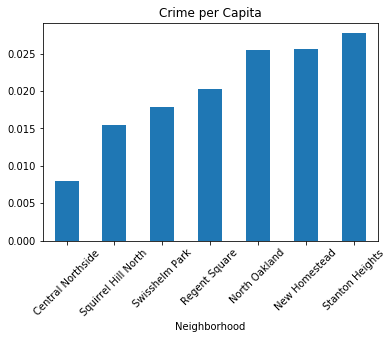

In [212]:
arrest_data_filtered.loc[:,'Offenses per Capita'].plot(kind="bar", title = "Crime per Capita", rot=45)

## Building Permits
### Importing Data

In [213]:
permit_data = pd.read_csv('pli-permit-summary-3.2020.csv')
population_data = pd.read_csv('total-population.csv')
neighborhoods = gpd.read_file('Neighborhoods_.shp')

Reads in the building permit data and displays the neighborhoods with the most building permits in the month of March.

Text(0.5, 0, 'Permits')

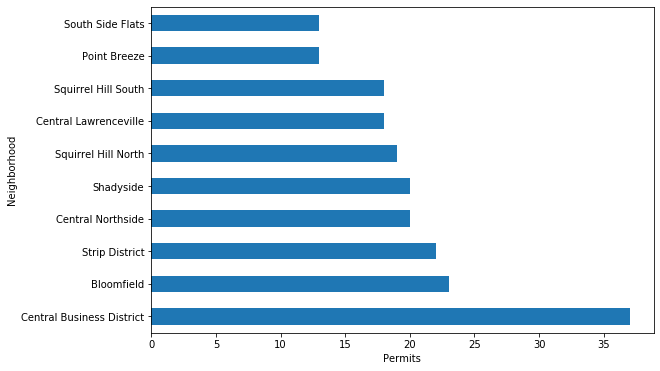

In [214]:
permit_data = permit_data.groupby('SNP_NEIGHBORHOOD').size()
permit_data = pd.DataFrame({'Neighborhood':permit_data.index, 'Permits':permit_data.values})
permit_data = permit_data.sort_values(by=['Permits'], ascending=False)
permit_data.head(10).plot.barh(x='Neighborhood', legend=False, figsize=(9, 6)).set_xlabel('Permits')

### People Per Permit Metric and Population
Reads in the population data and merges it with the permit data. Next, calculates the People Per Permit metric by dividing the population by the number of permits for each neighborhood, and displays the neighborhoods with the best People Per Permit metric that have a population over 2000.

In [215]:
combined_permit_data = pd.merge(permit_data, population_data)
combined_permit_data.drop(['Id', 'Margin of Error; Total'], inplace=True, axis=1)
combined_permit_data.columns.values[2] = 'Population'
combined_permit_data['People Per Permit'] = combined_permit_data.apply(lambda x: int(x.Population / x.Permits), axis=1)
combined_permit_data = combined_permit_data.set_index('Neighborhood')
refined_permit_data = combined_permit_data[combined_permit_data['Population'] > 2000]
refined_permit_data.sort_values(by=['People Per Permit'], ascending=True).head(10)

,Permits,Population,People Per Permit
Neighborhood,,,
Central Business District,37,4060,109
Central Northside,20,2892,144
East Allegheny,10,2095,209
Upper Lawrenceville,13,2754,211
Central Lawrenceville,18,4775,265
Lower Lawrenceville,8,2572,321
Crawford-Roberts,6,2225,370
Bloomfield,23,8669,376
Troy Hill,6,2283,380


Displays the neighborhoods with the worst People Per Permit metric that have a population over 2000.

In [216]:
refined_permit_data.sort_values(by=['People Per Permit'], ascending=False).head(10)

,Permits,Population,People Per Permit
Neighborhood,,,
Sheraden,1,5684,5684
Carrick,2,10122,5061
Overbrook,1,3682,3682
Brookline,4,13160,3290
Allentown,1,2558,2558
Spring Hill-City View,1,2456,2456
South Side Slopes,2,4583,2291
Brighton Heights,4,7421,1855
Lincoln Place,2,3499,1749


### Choropleth Map
Graphically displays the neighborhoods' People Per Permit metric using a choropleth map.

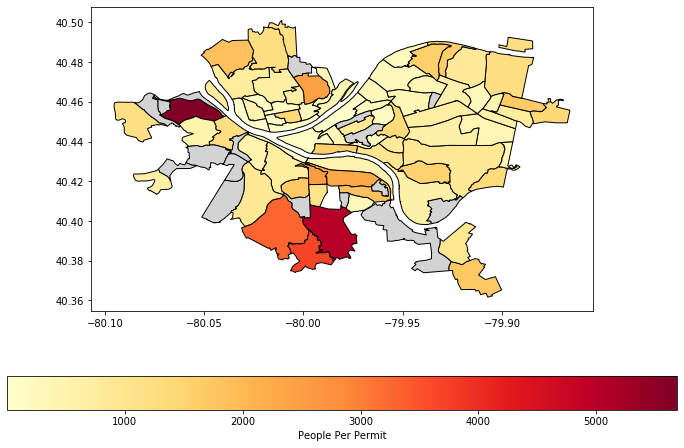

In [217]:
neighborhoods = neighborhoods.merge(combined_permit_data, how='left', left_on='hood', right_on='Neighborhood')
neighborhoods.plot(column='People Per Permit', cmap='YlOrRd', edgecolor='black', legend=True,
                 legend_kwds={'label':'People Per Permit', 'orientation':'horizontal'},
                 figsize=(12, 8), missing_kwds={'color':'lightgray'})

## Individuals In Poverty
### Importing Data

In [218]:
education = pd.read_csv('education-income.csv',
                           index_col="Neighborhood",
                           parse_dates=True)
s = pd.DataFrame(education)

s.head()

,Sector #,Population (2010),"Total Pop, 25 and older (2010)",Edu. Attainment: Less than High School (2010),Edu. Attainment: High School Graduate (2010),Edu. Attainment: Assoc./Prof. Degree (2010),Edu. Attainment: Bachelor's Degree (2010),Edu. Attainment: Postgraduate Degree (2010),1999 Median Income ('99 Dollars),2009 Median Income ('09 Dollars),1999 Median Income ('11 Dollars),2009 Med. Income ('13 Dollars),Est. Pop. for which Poverty Calc. (2010),Est. Pop. Under Poverty (2010),Est. Percent Under Poverty (2010)
Neighborhood,,,,,,,,,,,,,,,
Allegheny Center,3,933,609,18.7%,44.5%,17.2%,15.8%,3.8%,"$16,964","$20,911","$22,535","$22,793",954,324,34.0%
Allegheny West,3,462,239,9.2%,28.9%,6.7%,44.8%,10.5%,"$26,638","$41,761","$35,386","$45,519",239,12,5.0%
Allentown,6,"2,500","1,729",23.0%,63.3%,6.6%,5.6%,1.5%,"$22,539","$29,274","$29,941","$31,909","2,212",630,28.5%
Arlington,7,"1,869","1,232",14.9%,65.3%,10.1%,7.1%,2.5%,"$27,167","$25,119","$36,089","$27,380","1,779",361,20.3%
Arlington Heights,7,244,166,18.1%,74.1%,0.0%,7.8%,0.0%,"$18,646","$9,417","$24,769","$10,265",293,169,57.7%


We'll drop out the other columns other than the one that counts up our individuals in poverty.

In [219]:
del s['Sector #']
del s['Population (2010)']
del s['Total Pop, 25 and older (2010)']
del s['Edu. Attainment: Less than High School (2010)']
del s['Edu. Attainment: Assoc./Prof. Degree (2010)']
del s['Edu. Attainment: Bachelor\'s Degree (2010)']
del s['Edu. Attainment: Postgraduate Degree (2010)']
del s['1999 Median Income (\'99 Dollars)']
del s['2009 Median Income (\'09 Dollars)']
del s['1999 Median Income (\'11 Dollars)']
del s['2009 Med. Income (\'13 Dollars)']
del s['Est. Pop. for which Poverty Calc. (2010)']
del s['Est. Percent Under Poverty (2010)']
del s['Edu. Attainment: High School Graduate (2010)']

Next, we'll rename the column to something a little more consice and readable, and then we'll reprint the data with only that one column to simplify it a bit.

In [220]:
# renaming column to make it prettier
s = s.rename(columns={'Est. Pop. Under Poverty (2010)':'People Under Poverty Line'})

# reprinting with only our most recent column still in the dataframe
s.head()

,People Under Poverty Line
Neighborhood,
Allegheny Center,324
Allegheny West,12
Allentown,630
Arlington,361
Arlington Heights,169


## Sorting Data

The focus of the project is to measure neighborhood 'bestness', so what I'm doing here is sorting the data by who has the **least** number of people in their neighborhood under the poverty line. We're also going to filter out results higher than 100 so that the neighborhoods play nicely with the bar graph.

In [221]:
# sorting the data in ascending order to show the highest levels of blood lead

# removing the commas from the column and parsing the va
s['People Under Poverty Line'] = s['People Under Poverty Line'].replace({',':''}, regex=True)
s[["People Under Poverty Line"]] = s[["People Under Poverty Line"]].apply(pd.to_numeric)

In [222]:
poverty_levels = s[s['People Under Poverty Line']<100].sort_values('People Under Poverty Line',ascending=True)
poverty_levels_table = s.sort_values('People Under Poverty Line',ascending=True)

poverty_levels.head(30)

,People Under Poverty Line
Neighborhood,
North Shore,0
South Shore,0
West End,0
Strip District,10
Allegheny West,12
Regent Square,12
Chartiers City,22
Swisshelm Park,30
East Carnegie,32


## Representation

We're going to set up the previously mentioned bar graph and display our data, which will show the neighborhoods with the best results (remember, lower is better).

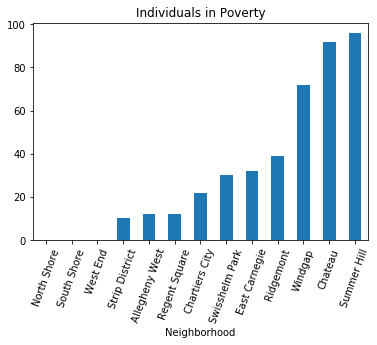

In [223]:
# setting up bar graph
poverty_levels.loc[:,'People Under Poverty Line'].plot(kind="bar", title = "Individuals in Poverty", rot=70)

## The Best Neighborhood

Assigns a rank value to each neighborhood in each dataframe then adds them all up to determine which neighborhood is the best. A lower rank indicates a better neighborhood.

In [230]:
arrest_data = arrest_data.sort_values(by=['Offenses per Capita'], ascending=True)
refined_permit_data = refined_permit_data.sort_values(by=['People Per Permit'], ascending=True)
arrest_data['Rank1'] = np.arange(len(arrest_data))
refined_permit_data['Rank2'] = np.arange(len(refined_permit_data))
poverty_levels_table['Rank3'] = np.arange(len(poverty_levels_table))
final_data = pd.merge(left=arrest_data, right=refined_permit_data, left_on='Neighborhood', right_on='Neighborhood')
final_data = pd.merge(left=final_data, right=poverty_levels_table, left_on='Neighborhood', right_on='Neighborhood')
final_data['Rank'] = final_data.apply(lambda x: int(x.Rank1 + x.Rank2 + x.Rank3 + 3), axis=1)
final_data = final_data.sort_values(by='Rank', ascending=False)

Text(0.5, 0, 'Rank')

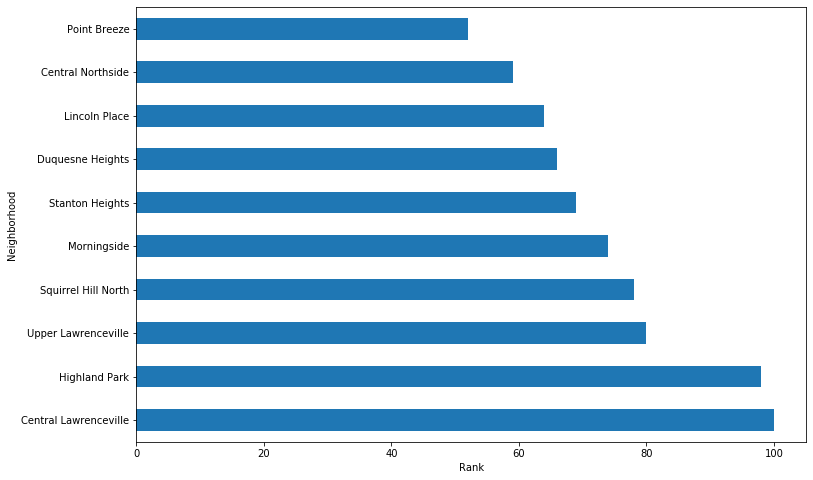

In [231]:
final_data.tail(10).plot.barh(y='Rank', legend=False, figsize=(12, 8)).set_xlabel('Rank')

## Conclusion
### Erik
* I hadn't heard of Point Breeze before we combined our data and determined the best neighborhood. After looking it up, I'm not surprised given its close proximity to other very desirable neighborhoods. Squirrel Hill is my favorite neighborhood, and I honestly expected it to be higher up on the list; rank 7 is not too bad though.

### Albert
* I haven't seen many neighborhoods around Pittsburgh but based on what I have seen the conclusion that we came to seems to be correct.

### Brendan
* I’ve lived in Pittsburgh my entire life, and the results from my metric did little to change my mind about where I’d be interested in living or spending my time, but each of these results demonstrates something about these neighborhoods that is the “best” for entirely different reasons, and I think that’s worth exploring.